In [1]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
from bs4 import BeautifulSoup

import torch
import requests

import os

from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

rates = requests.get("https://api.exchangerate-api.com/v4/latest/USD").json()['rates']
rates['RUR'] = rates['RUB']
rates['BYR'] = rates['BYN']

In [2]:
import glob

# Read all files with name starting with 'full_vacs'
file_paths = glob.glob('full_vacs*.parquet')

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the file paths and read each file into a DataFrame
for file_path in file_paths:
    df_temp = pd.read_parquet(file_path)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
print(df.columns)
df = df.drop_duplicates(subset='id')
df = df[['id', 'name', 'area', 'address', 'salary', 'experience', 'schedule', 'employment', 'description', 'key_skills', 'professional_roles', 'published_at', 'languages', 'employer']]

df['area'] = df['area'].apply(lambda area: area['name'])
df['currency'] = df['salary'].apply(lambda salary: salary['currency'])
df['experience'] = df['experience'].apply(lambda exp: exp['name'])
df['schedule'] = df['schedule'].apply(lambda sch: sch['name'])
df['employment'] = df['employment'].apply(lambda emp: emp['name'])
df['key_skills'] = df['key_skills'].apply(lambda ks: list(map(lambda s: s['name'].lower(), ks)))
df['professional_roles'] = df['professional_roles'].apply(lambda prs: list(map(lambda pr: pr['name'], prs))[0])
df['published_at'] = pd.to_datetime(df['published_at'])
df['published_date'] = df['published_at'].dt.date
df['description'] = df['description'].apply(lambda desc: BeautifulSoup(desc).get_text().lower())
df['employer'] = df['employer'].apply(lambda employer: employer['name'])

df['salary_from'] = df['salary'].apply(lambda salary: salary['from'])
df['salary_to'] = df['salary'].apply(lambda salary: salary['to'])

salary_range_pct = 25.0

def calculate_mean_salary(row, pct):
    if pd.notna(row['salary_from']) and pd.notna(row['salary_to']):
        return (row['salary_from'] + row['salary_to']) / 2
    elif pd.notna(row['salary_from']):
        return row['salary_from'] * (1 + pct / 100)
    elif pd.notna(row['salary_to']):
        return row['salary_to'] * (1 - pct / 100)
    else:
        return np.nan


df['mean_salary'] = df.apply(lambda row: calculate_mean_salary(row, salary_range_pct), axis=1)
df['mean_salary_usd'] = df.apply(lambda row: row['mean_salary'] / rates[row['currency']], axis=1)

df = df.drop(columns=['address'])

area_counts = df['area'].value_counts()
areas_with_more_than_10_entries = area_counts[area_counts > 10].index

df = df[df['area'].isin(areas_with_more_than_10_entries)]

currency_counts = df['currency'].value_counts()
currency_with_more_than_100_entries = currency_counts[currency_counts > 100].index

df = df[df['currency'].isin(currency_with_more_than_100_entries)]

# If vacancy contains word высшее or higher than we can assume that higher education is required
df['education'] = df['description'].apply(lambda desc: int("высшее" in desc or "higher" in desc))

Index(['id', 'premium', 'billing_type', 'relations', 'name',
       'insider_interview', 'response_letter_required', 'area', 'salary',
       'type', 'address', 'allow_messages', 'experience', 'schedule',
       'employment', 'department', 'contacts', 'description',
       'branded_description', 'vacancy_constructor_template', 'key_skills',
       'accept_handicapped', 'accept_kids', 'archived', 'response_url',
       'specializations', 'professional_roles', 'code', 'hidden',
       'quick_responses_allowed', 'driver_license_types',
       'accept_incomplete_resumes', 'employer', 'published_at', 'created_at',
       'initial_created_at', 'negotiations_url', 'suitable_resumes_url',
       'apply_alternate_url', 'has_test', 'test', 'alternate_url',
       'working_days', 'working_time_intervals', 'working_time_modes',
       'accept_temporary', 'languages', 'approved', 'video_vacancy',
       'immediate_redirect_url', 'immediate_redirect_vacancy_id'],
      dtype='object')


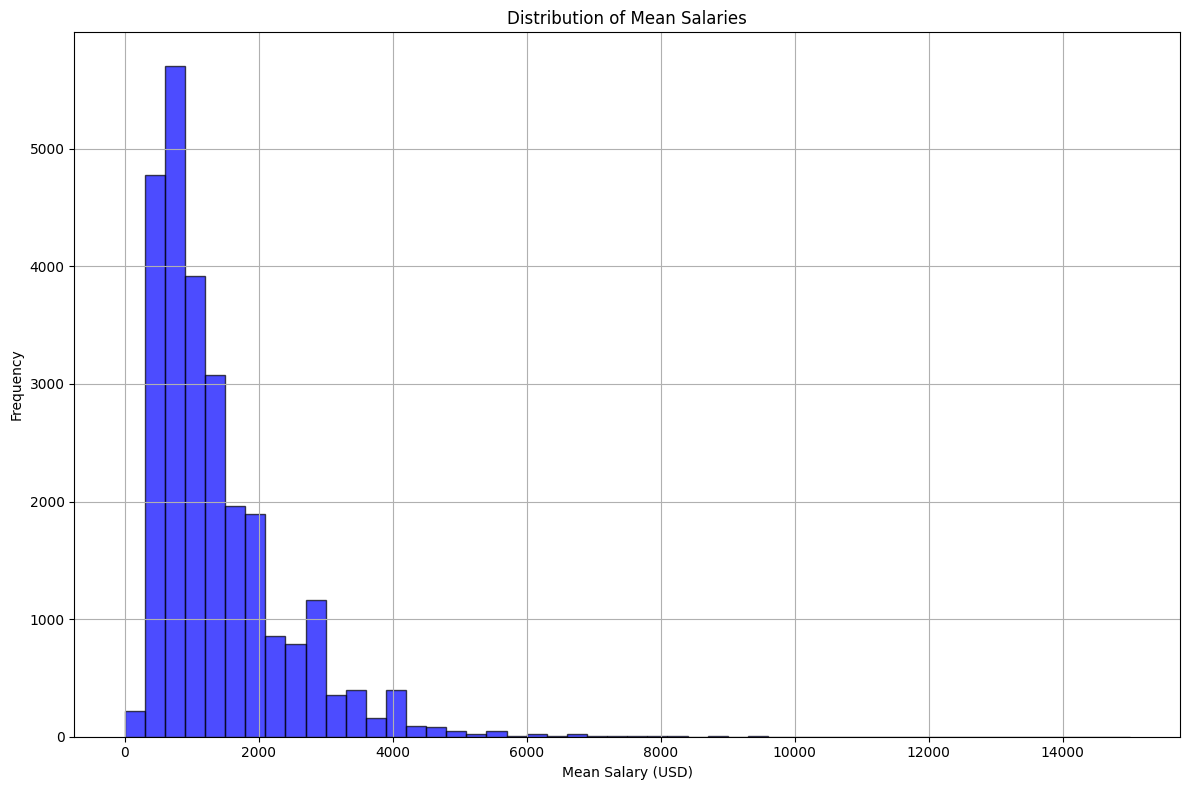

In [3]:
import matplotlib.pyplot as plt

# Plotting the distribution of mean salaries
plt.figure(figsize=(12, 8))
plt.hist(df['mean_salary_usd'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Mean Salary (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Salaries')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

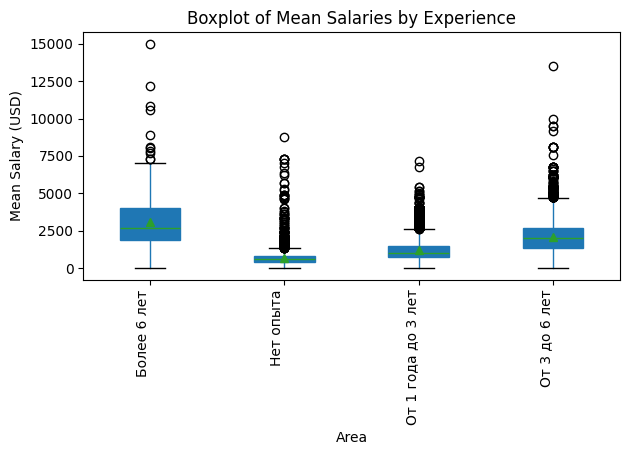

In [4]:
import matplotlib.pyplot as plt

# Plotting boxplots of mean USD salary by area
plt.figure(figsize=(16, 10))
df.boxplot(column='mean_salary_usd', by='experience', grid=False, vert=True, patch_artist=True, showmeans=True)

plt.xlabel('Area')
plt.ylabel('Mean Salary (USD)')
plt.title('Boxplot of Mean Salaries by Experience')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


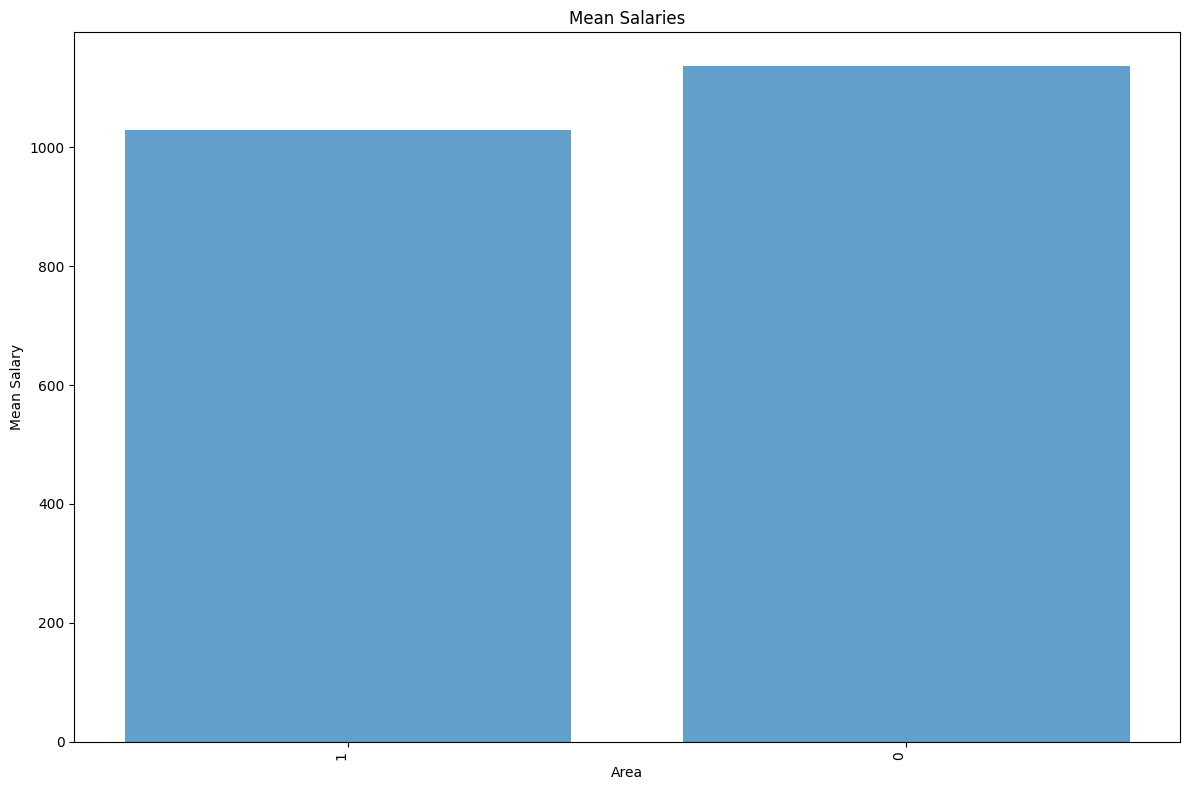

In [5]:
import matplotlib.pyplot as plt

# Group by area and calculate the mean of mean_salary
area_mean_salary = df.groupby('education')['mean_salary_usd'].median().sort_values(ascending=False)

# Plotting the mean salaries by area
plt.figure(figsize=(12, 8))
plt.bar(area_mean_salary.index, area_mean_salary.values, alpha=0.7)

plt.xlabel('Area')
plt.ylabel('Mean Salary')
plt.title('Mean Salaries')
plt.xticks(ticks=range(len(area_mean_salary.index)), labels=area_mean_salary.index, rotation=90, ha='right')
plt.tight_layout()
plt.show()


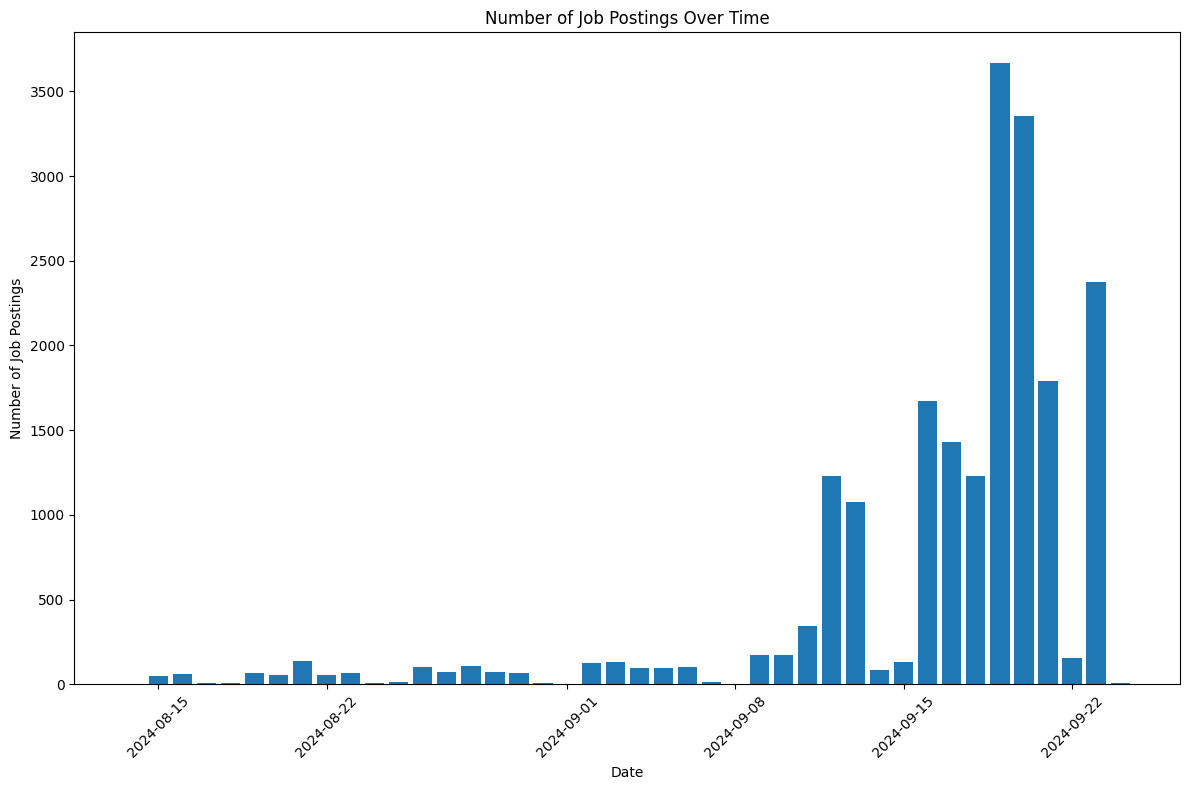

In [60]:
import matplotlib.pyplot as plt

published_date_counts = df.groupby('published_date').size()

plt.figure(figsize=(12, 8))
plt.bar(published_date_counts.index, published_date_counts.values)

plt.xlabel('Date')
plt.ylabel('Number of Job Postings')
plt.title('Number of Job Postings Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
from vllm import LLM, SamplingParams

os.environ["VLLM_ATTENTION_BACKEND"] = "FLASHINFER"
os.environ["HF_TOKEN"] = os.environ['HF_TOKEN']

llm = LLM("google/gemma-2-2b-it", dtype=torch.bfloat16)

WARNING 09-24 13:32:51 utils.py:727] Gemma 2 uses sliding window attention for every odd layer, which is currently not supported by vLLM. Disabling sliding window and capping the max length to the sliding window size (4096).
INFO 09-24 13:32:51 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='google/gemma-2-2b-it', speculative_config=None, tokenizer='google/gemma-2-2b-it', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=No

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 09-24 13:33:03 model_runner.py:1008] Loading model weights took 4.8999 GB
INFO 09-24 13:33:07 gpu_executor.py:122] # GPU blocks: 1213, # CPU blocks: 2520
INFO 09-24 13:33:07 model_runner.py:1311] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 09-24 13:33:07 model_runner.py:1315] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 09-24 13:33:25 model_runner.py:1430] Graph capturing finished in 18 secs.


In [8]:
sampling_params = SamplingParams(temperature=0, top_p=0.95, max_tokens=512)

In [9]:
def build_manager_prompt(name: str):
    return f"""
<start_of_turn>user
Here is a name of job vacancy. You need to check if this is role in IT industry
Return only 1 or 0
Name: {name}
<end_of_turn>
<start_of_turn>model
"""


result = llm.generate(list(map(build_manager_prompt, list(df['name']))), sampling_params)

df['is_it'] = [int(res.outputs[0].text.strip().lower() == '1') for res in result]

Processed prompts: 100%|██████████| 26047/26047 [02:02<00:00, 211.88it/s, est. speed input: 10641.14 toks/s, output: 847.51 toks/s]


In [10]:
df = df[df.is_it.eq(1)]
df = df.drop(columns=['is_it'])

In [12]:
def build_manager_prompt(name: str):
    return f"""
<start_of_turn>user
Here is a name of job vacancy. You need too determine if this is a manager role
Return only 1 or 0
Name: {name}
<end_of_turn>
<start_of_turn>model
"""


result = llm.generate(list(map(build_manager_prompt, list(df['name']))), sampling_params)

df['manager'] = [int(res.outputs[0].text.strip().lower() == '1') for res in result]

Processed prompts: 100%|██████████| 20426/20426 [01:33<00:00, 218.29it/s, est. speed input: 10796.30 toks/s, output: 873.17 toks/s]


In [13]:
def build_techstack_prompt(params):
    return f"""
<start_of_turn>user
Here is a name of job vacancy, description and key skills. Return tech stack required in this vacancy in format [technology_1, technology_2, technology_n].
Return only list of technologies
Name: {params[0]}
Key skills: {params[1]}
Description: {params[2]}
<end_of_turn>
<start_of_turn>model
"""

result = llm.generate(list(map(build_techstack_prompt, list(zip(df['name'], df['key_skills'], df['description'])))), sampling_params)

def parse_techstack(string: str):
    cleaned_string = string.replace('[', '').replace(']', '')
    tech_stack_list = [tech.strip() for tech in cleaned_string.split(',')]
    return tech_stack_list

df['tech_stack'] = [parse_techstack(res.outputs[0].text.strip().lower()) for res in result]

Processed prompts:   3%|▎         | 559/20426 [00:38<25:31, 12.97it/s, est. speed input: 7872.25 toks/s, output: 437.15 toks/s]

WARNING 09-24 13:39:22 scheduler.py:1362] Sequence group 47060 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 20426/20426 [21:55<00:00, 15.53it/s, est. speed input: 8446.30 toks/s, output: 470.71 toks/s]


In [15]:
def build_role_prompt(params):
    return f"""
<start_of_turn>user
Here is a description of job vacancy. Return role name that will describe this vacancy.
Return only general role description like ML Engineer, Software Developer, Backend Developer, Head of Analytics etc
DO NOT ADD LANGUAGE OR SOFTWARE TO ROLE NAME
USE ONLY ENGLISH
Return only name
Name: {params[0]}
Description: {params[1]}
<end_of_turn>
<start_of_turn>model
"""

result = llm.generate(list(map(build_role_prompt, list(zip(df['name'], df['description'])))), sampling_params)

df['role'] = [res.outputs[0].text.strip().lower() for res in result]

Processed prompts: 100%|██████████| 20426/20426 [15:19<00:00, 22.21it/s, est. speed input: 11707.49 toks/s, output: 117.64 toks/s]


Need to reset gpu memory

In [16]:
df.to_parquet('generated_nlp_features.parquet')

In [2]:
df = pd.read_parquet('generated_nlp_features.parquet')
df.shape

(20426, 23)

In [3]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()

/home/netkit/Projects/analytics/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
from sklearn.cluster import DBSCAN

def find_clusters(embeddings, strings, eps=0.05):
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    clusters = dbscan.fit_predict(embeddings)

    # Create a dictionary to store clusters
    clustered_skills = {}
    for idx, label in enumerate(clusters):
        if label == -1:
            continue  # Skip noise
        if label not in clustered_skills:
            clustered_skills[label] = []
        clustered_skills[label].append(strings[idx])

    # Convert lists to sets for better handling of unique skills
    clustered_skills = {k: set(v) for k, v in clustered_skills.items()}

    return clustered_skills

In [5]:
unique_roles = df['role'].dropna().explode().str.strip().dropna().unique()

roles_embeddings = embedding_model.encode(list(unique_roles))
roles_clusters = find_clusters(roles_embeddings, unique_roles, eps=0.05)

print(f'unique roles: {len(unique_roles)}')

unique_tech_stacks = df['tech_stack'].dropna().explode().str.strip().dropna().unique()

tech_stack_embeddings = embedding_model.encode(list(unique_tech_stacks))
tech_stack_clusters = find_clusters(tech_stack_embeddings, unique_tech_stacks, eps=0.05)

print(f'unique tech_stacks: {len(unique_tech_stacks)}')

unique roles: 1108
unique tech_stacks: 12785


In [7]:
def build_cluster_map(clusters):
    cluster_map = {}

    for strings in list(clusters.values()):
        embs = embedding_model.encode(list(strings))
        similarity_matrix = cosine_similarity(embs)
        mean_distances = np.mean(1 - similarity_matrix, axis=1)

        best_string = list(strings)[np.argmin(mean_distances)]

        for string in strings:
            cluster_map[string] = best_string
    
    return cluster_map

role_map = build_cluster_map(roles_clusters)

def map_role(role):
    if role in role_map:
        return role_map[role]
    
    return role

print(f"roles before collapsing: {len(df['role'].dropna().explode().str.strip().dropna().unique())}")
df['role'] = df['role'].apply(map_role)
print(f"roles after collapsing: {len(df['role'].dropna().explode().str.strip().dropna().unique())}")


techstack_map = build_cluster_map(tech_stack_clusters)

def map_techstack(tech_stack):
    if tech_stack in techstack_map:
        return techstack_map[tech_stack]
    
    return tech_stack

print(f"skills before collapsing: {len(df['tech_stack'].dropna().explode().str.strip().dropna().unique())}")
df['tech_stack'] = df['tech_stack'].apply(lambda x: [map_techstack(ts) for ts in x])
print(f"skills after collapsing: {len(df['tech_stack'].dropna().explode().str.strip().dropna().unique())}")

roles before collapsing: 1108
roles after collapsing: 964
skills before collapsing: 12785
skills after collapsing: 9917


Encode categorial features

In [8]:
# ['role', 'area', 'experience', 'schedule', 'employment', 'currency']

# One-hot encode 'experience', 'schedule', 'employment', and 'currency'
encoded_columns = ['experience', 'schedule', 'employment', 'currency']
df_encoded = pd.get_dummies(df[encoded_columns], columns=encoded_columns, drop_first=True)

# Concatenate the encoded columns back to the original dataframe
df = pd.concat([df, df_encoded], axis=1)

# Drop the original columns as they are now encoded
df.drop(columns=encoded_columns, inplace=True)

# Define the target variable
target = 'mean_salary_usd'

# Calculate mean target encoding for 'role'
role_mean_target = df.groupby('role')[target].mean()
df['role_mean_target'] = df['role'].map(role_mean_target)

# Calculate mean target encoding for 'area'
area_mean_target = df.groupby('area')[target].mean()
df['area_mean_target'] = df['area'].map(area_mean_target)

# Drop the original 'role' and 'area' columns as they are now encoded
df.drop(columns=['role', 'area'], inplace=True)

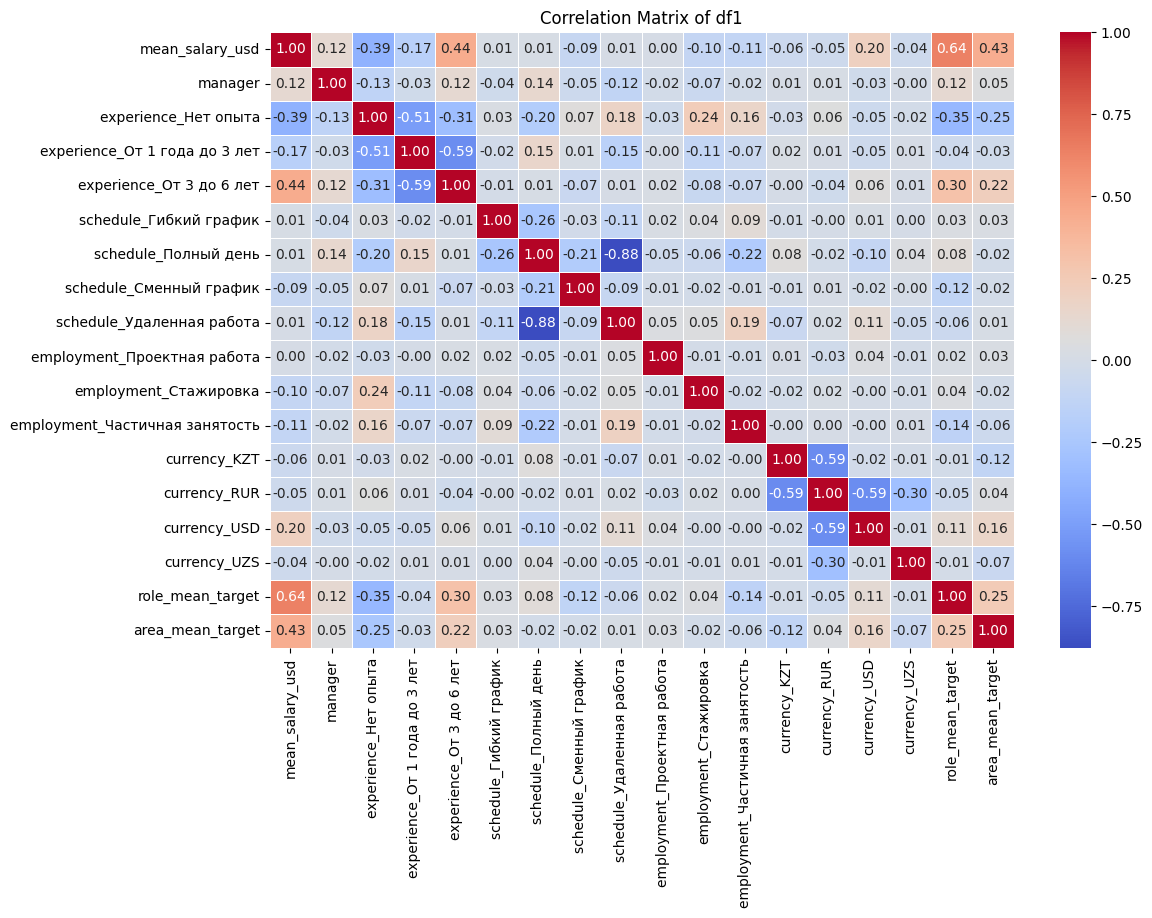

In [12]:
df1 = df.drop(columns=['professional_roles', 'description', 'key_skills', 'mean_salary', 'salary_from', 'salary_to', 'id', 'published_at', 'published_date', 'languages', 'name', 'salary', 'employer', 'education'])

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df1.drop(columns=['tech_stack']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of df1')
plt.show()

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tech_stack_encoded = mlb.fit_transform(df1['tech_stack'])
tech_stack_df = pd.DataFrame(tech_stack_encoded, columns=mlb.classes_)

df1 = pd.concat([df1.reset_index(drop=True), tech_stack_df.reset_index(drop=True)], axis=1)
df1.drop(columns=['tech_stack'], inplace=True)


In [13]:
def weighted_mape(y_true, y_pred, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (Weighted MAPE).
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) - Estimated target values.
    - weights: array-like of shape (n_samples,), optional - Weights for each sample. If None, use y_true as weights.
    
    Returns:
    - weighted_mape_value: float - The weighted MAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Default weights to y_true if not provided
    if weights is None:
        weights = np.abs(y_true)
    
    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    
    # Weighted Mean Absolute Percentage Error
    weighted_mape_value = np.sum(weights * ape) / np.sum(weights) * 100
    
    return weighted_mape_value

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    wmape = weighted_mape(y_test, y_pred)

    print(f"Mean Absolute Percentage Error: {mape}")
    print(f"Weighted Mean Absolute Percentage Error: {wmape}")
    print(f"R-squared: {r2}")
    print(f"Mean Absolute Error: {mae}")

    return {
        "r2": r2,
        "mae": mae,
        "mape": mape,
        "wmape": wmape,
    }

In [19]:
from sklearn.model_selection import train_test_split

X = df1.drop(columns=['mean_salary_usd'])
y = df1['mean_salary_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from catboost import CatBoostRegressor, Pool

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

catboost_model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    loss_function='MAE',
    early_stopping_rounds=50,
)

catboost_model.fit(train_pool, eval_set=test_pool)

y_pred_cb = catboost_model.predict(X_test)

import matplotlib.pyplot as plt

feature_importances = catboost_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'][:20], feature_importance_df['importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()
plt.show()


In [21]:
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid_search.fit(X_train, y_train)
best_ridge = grid_search.best_estimator_

y_pred_ridge = best_ridge.predict(X_test)

Best parameters for Ridge regression: {'alpha': 10.0}


In [22]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

Mean Absolute Percentage Error: 1.5917204439848027
Weighted Mean Absolute Percentage Error: 29.00952564524411
R-squared: 0.6568627058372931
Mean Absolute Error: 415.5287153029509
Mean Absolute Percentage Error: 1.1347930522462772
Weighted Mean Absolute Percentage Error: 25.2065409939036
R-squared: 0.683580351842553
Mean Absolute Error: 361.0552521442235
Mean Absolute Percentage Error: 1.2246647243588284
Weighted Mean Absolute Percentage Error: 24.934816466468916
R-squared: 0.695786492337324
Mean Absolute Error: 357.1631049515393
Comparison of Model Results:
       Ridge Regression  Random Forest    CatBoost
r2             0.656863       0.683580    0.695786
mae          415.528715     361.055252  357.163105
mape           1.591720       1.134793    1.224665
wmape         29.009526      25.206541   24.934816


<Figure size 1200x800 with 0 Axes>

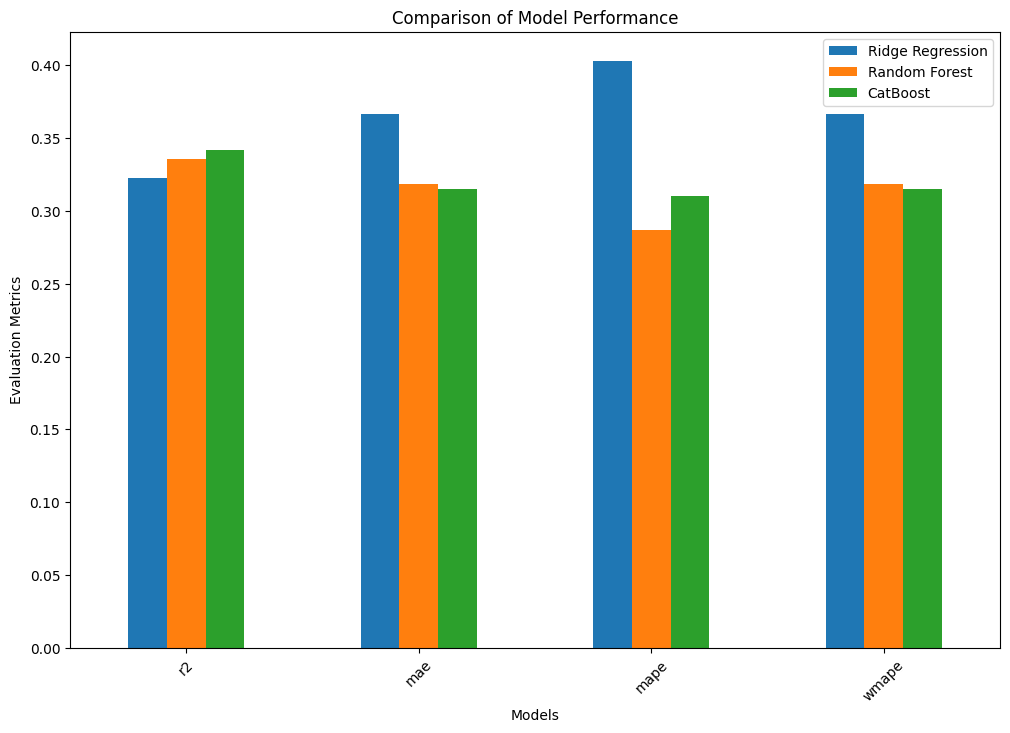

In [23]:
results = {
    'Ridge Regression': evaluate(y_test, y_pred_ridge),
    'Random Forest': evaluate(y_test, y_pred_rf),
    'CatBoost': evaluate(y_test, y_pred_cb),
}

results_df = pd.DataFrame(results)
normalized_results_df = results_df.div(results_df.sum(axis=1), axis=0)

print("Comparison of Model Results:")
print(results_df)

plt.figure(figsize=(12, 8))
normalized_results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Model Performance')
plt.xlabel('Models')
plt.ylabel('Evaluation Metrics')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()
